In [1]:
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from google.colab import files
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D


%matplotlib inline

In [2]:
# import file
dataFile = files.upload()

Saving data.csv to data.csv


In [3]:
# creating dataframe, having a look-see
df = pd.read_csv(io.BytesIO(dataFile['data.csv']))
df.head()

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.995,['Carl Woitschach'],0.708,158648,0.1950,0,6KbQ3uYMLKb5jDxLF7wYDD,0.563,10,0.1510,-12.428,1,Singende Bataillone 1. Teil,0,1928,0.0506,118.469,0.7790,1928
1,0.994,"['Robert Schumann', 'Vladimir Horowitz']",0.379,282133,0.0135,0,6KuQTIu1KoTTkLXKrwlLPV,0.901,8,0.0763,-28.454,1,"Fantasiestücke, Op. 111: Più tosto lento",0,1928,0.0462,83.972,0.0767,1928
2,0.604,['Seweryn Goszczyński'],0.749,104300,0.2200,0,6L63VW0PibdM1HDSBoqnoM,0.000,5,0.1190,-19.924,0,Chapter 1.18 - Zamek kaniowski,0,1928,0.9290,107.177,0.8800,1928
3,0.995,['Francisco Canaro'],0.781,180760,0.1300,0,6M94FkXd15sOAOQYRnWPN8,0.887,1,0.1110,-14.734,0,Bebamos Juntos - Instrumental (Remasterizado),0,1928-09-25,0.0926,108.003,0.7200,1928
4,0.990,"['Frédéric Chopin', 'Vladimir Horowitz']",0.210,687733,0.2040,0,6N6tiFZ9vLTSOIxkj8qKrd,0.908,11,0.0980,-16.829,1,"Polonaise-Fantaisie in A-Flat Major, Op. 61",1,1928,0.0424,62.149,0.0693,1928


In [4]:
# feature selection
df_features = df[['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']]
df_features.head()

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
0,0.995,0.708,0.1950,0.563,0.1510,-12.428,0.0506,118.469,0.7790
1,0.994,0.379,0.0135,0.901,0.0763,-28.454,0.0462,83.972,0.0767
2,0.604,0.749,0.2200,0.000,0.1190,-19.924,0.9290,107.177,0.8800
3,0.995,0.781,0.1300,0.887,0.1110,-14.734,0.0926,108.003,0.7200
4,0.990,0.210,0.2040,0.908,0.0980,-16.829,0.0424,62.149,0.0693


In [5]:
# standardizing the continuous variables using sklearn StandardScaler
scaler = MinMaxScaler()
df_std = pd.DataFrame(scaler.fit_transform(df_features), columns=df_features.columns)
np_std = df_std.to_numpy()
df_std.head()

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
0,0.998996,0.716599,0.1950,0.563,0.1510,0.745000,0.052219,0.485348,0.7790
1,0.997992,0.383603,0.0135,0.901,0.0763,0.494026,0.047678,0.344019,0.0767
2,0.606426,0.758097,0.2200,0.000,0.1190,0.627609,0.958720,0.439086,0.8800
3,0.998996,0.790486,0.1300,0.887,0.1110,0.708887,0.095562,0.442470,0.7200
4,0.993976,0.212551,0.2040,0.908,0.0980,0.676079,0.043756,0.254614,0.0693


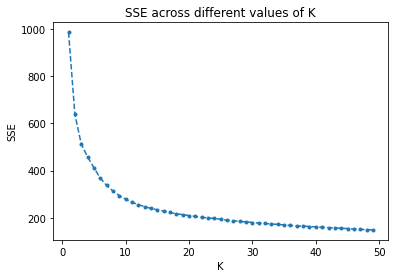

In [7]:
# determine optimal number of clusters (elbow method)
km = KMeans()
sse = []
sample = df_std.sample(2000)
for k in range(1, 50):
  km = KMeans(n_clusters=k, random_state=10)
  km.fit(sample)
  sse.append(km.inertia_)

plt.plot(range(1,50), sse, marker='o', ms=3, linestyle='--')
plt.xlabel('K')
plt.ylabel('SSE')
plt.title('SSE across different values of K')
plt.show()

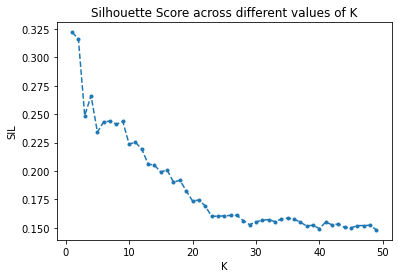

In [8]:
sil = []
for k in range(2, 50+1):
  kmeans = KMeans(n_clusters = k, random_state=10).fit(sample)
  labels = kmeans.predict(sample)
  sil.append(silhouette_score(sample, labels, metric = 'euclidean'))

plt.plot(range(1,50), sil,  marker='o', ms=3, linestyle='--')
plt.xlabel('K')
plt.ylabel('SIL')
plt.title('Silhouette Score across different values of K')
plt.show()


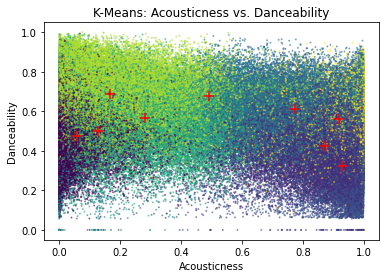

In [15]:
# train the KMeans model using 9 clusters
start = time.time()

km = KMeans(n_clusters=9)
km.fit(np_std)

labels = km.predict(np_std)
centers = km.cluster_centers_

end = time.time()
km_time = end - start

plt.scatter(np_std[:, 0], np_std[:, 1], c=labels, s=1, cmap='viridis', alpha=0.5)
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=100, marker='+')
plt.xlabel('Acousticness')
plt.ylabel('Danceability')
plt.title('K-Means: Acousticness vs. Danceability')
plt.show()

In [17]:
# evaluating metrics
km_sil_score = silhouette_score(np_std, labels)
km_cb_score = calinski_harabasz_score(np_std, labels)

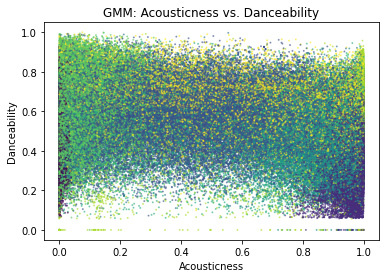

In [18]:
# train GMM using 9 components
start = time.time()

gmm = GaussianMixture(n_components=9, covariance_type='diag')
gmm.fit(np_std)

labels = gmm.predict(np_std)

end = time.time()
gmm_time = end - start

plt.scatter(np_std[:, 0], np_std[:, 1], c=labels, s=1, cmap='viridis', alpha=0.5)
plt.xlabel('Acousticness')
plt.ylabel('Danceability')
plt.title('GMM: Acousticness vs. Danceability')
plt.show()



In [19]:
# evaluating metrics
gmm_sil_score = silhouette_score(np_std, labels)
gmm_cb_score = calinski_harabasz_score(np_std, labels)

print(gmm_sil_score)
print(gmm_cb_score)


0.0360491757479108
19545.09481677581


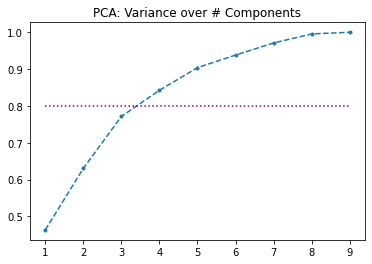

In [20]:
# find optimal number of PCA components (variance ~= 0.8)
pca = PCA()
pca.fit(np_std)
plt.plot(range(1,10), pca.explained_variance_ratio_.cumsum(), marker='o', ms=3, linestyle='--')
plt.plot(range(1,10), np.repeat(0.8, 9), c='purple', linestyle=':')
plt.title('PCA: Variance over # Components')
plt.show()

In [21]:
# fit the model to the training data using 3 components
pca = PCA(n_components=3)
pca.fit(np_std)
np_pca = pca.transform(np_std)

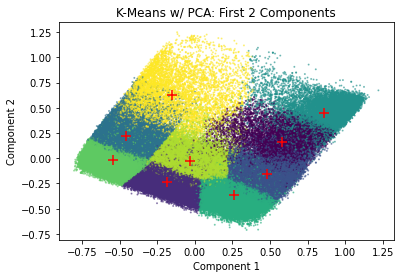

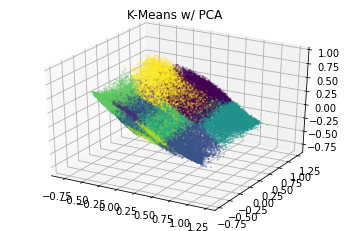

In [39]:
# retrain the KMeans model using the PCA Scores
start = time.time()
km = KMeans(n_clusters=9)
km.fit(np_pca)

labels = km.predict(np_pca)
centers = km.cluster_centers_

end = time.time()
km_pca_time = end -start

plt.scatter(np_pca[:, 0], np_pca[:, 1], c=labels, s=1, cmap='viridis', alpha=0.5)
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=100, marker='+')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('K-Means w/ PCA: First 2 Components')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(np_pca[:, 0], np_pca[:, 1], np_pca[:, 2], zdir='z', c=labels, s=1, cmap='viridis', alpha=0.25)
plt.title('K-Means w/ PCA')
fig.show()

In [24]:
# evaluating metrics
km_pca_sil_score = silhouette_score(np_pca, labels)
km_pca_cb_score = calinski_harabasz_score(np_pca, labels)

print(km_pca_sil_score)
print(km_pca_cb_score)

0.37154479698823
140432.89339842935


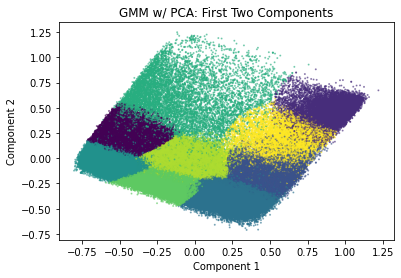

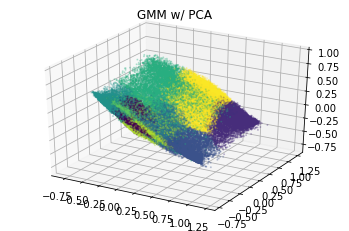

In [34]:
# retrain the GMM using the PCA Scores
start = time.time()

gmm = GaussianMixture(n_components=9, covariance_type= 'diag')
gmm.fit(np_pca)
labels = gmm.predict(np_pca)

end = time.time()
gmm_pca_time = end - start

plt.scatter(np_pca[:, 0], np_pca[:, 1], c=labels, s=1, cmap='viridis', alpha=0.5)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('GMM w/ PCA: First Two Components')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(np_pca[:, 0], np_pca[:, 1], np_pca[:, 2], zdir='z', c=labels, s=1, cmap='viridis', alpha=0.25)
plt.title('GMM w/ PCA')
fig.show()


In [26]:
# evaluating metrics
gmm_pca_sil_score = silhouette_score(np_pca, labels)
gmm_pca_cb_score = calinski_harabasz_score(np_pca, labels)

print(gmm_pca_sil_score)
print(gmm_pca_cb_score)

0.32423678757883495
107649.06405657162


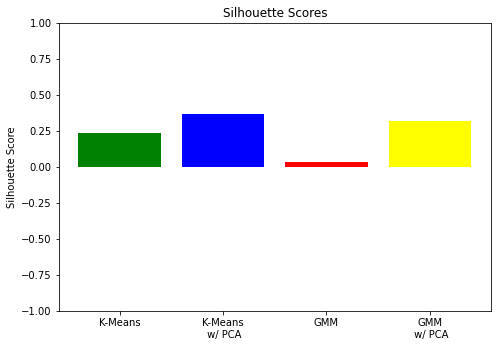

In [41]:
# plotting the silhouette scores
algos = ["K-Means", "K-Means\n w/ PCA", "GMM", "GMM\n w/ PCA"]
scores = [km_sil_score, km_pca_sil_score, gmm_sil_score, gmm_pca_sil_score]
colors = ['green', 'blue', 'red', 'yellow']

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(algos, scores, color = colors)
plt.ylim(-1.0, 1.0)
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores')

fig.show()

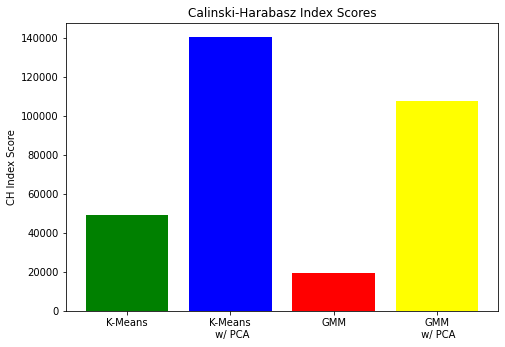

In [42]:
# plotting the cb scores
algos = ["K-Means", "K-Means\n w/ PCA", "GMM", "GMM\n w/ PCA"]
scores = [km_cb_score, km_pca_cb_score, gmm_cb_score, gmm_pca_cb_score]
colors = ['green', 'blue', 'red', 'yellow']

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(algos, scores, color = colors)
plt.ylabel('CH Index Score')
plt.title('Calinski-Harabasz Index Scores')
fig.show()

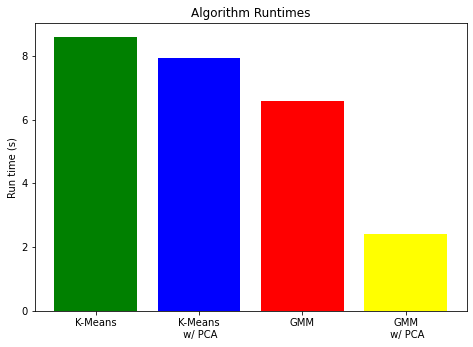

In [43]:
#Plotting runtime
algos = ["K-Means", "K-Means\n w/ PCA", "GMM", "GMM\n w/ PCA"]
scores = [km_time, km_pca_time, gmm_time, gmm_pca_time]
colors = ['green', 'blue', 'red', 'yellow']

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(algos, scores, color = colors)
plt.ylabel('Run time (s)')
plt.title('Algorithm Runtimes')
fig.show()

In [1]:
import os
os.system('jupyter nbconvert --to html Genre_Clustering.ipynb')

0